In [296]:
import pandas as pd
import numpy as np
import os
import datetime
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader ,TensorDataset
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F


In [3]:
os.listdir('.')

['Untitled.ipynb',
 'X_train.csv',
 '.ipynb_checkpoints',
 'Y_train.csv',
 'Y_test.csv',
 'X_test.csv']

In [105]:
X_train=pd.read_csv('X_train.csv',sep=';')
Y_train=pd.read_csv('Y_train.csv',sep=';')
X_test=pd.read_csv('X_test.csv',sep=';')
Y_test=pd.read_csv('Y_test.csv',sep=';')


# Checking if the traina nd test ids are present in each other 

In [17]:
print(set(X_train['key']).difference(X_test['key']))
print(set(X_test['key']).difference(X_train['key']))

set()
set()


# Converting X_Train and X_Test features

In [108]:
features_columns=list(set(X_train.columns).difference(set(['key','date'])))

In [109]:
X_train[features_columns]=X_train[features_columns].apply(lambda a: a.replace(",",'.',regex=True)).astype(float)
X_test[features_columns]=X_test[features_columns].apply(lambda a: a.replace(",",'.',regex=True)).astype(float)
Y_train[['y']]=Y_train[['y']].apply(lambda a: a.replace(",",'.',regex=True)).astype(float)


# Convering dates to date time 

In [106]:
X_train['date']=pd.to_datetime(X_train['date'])
X_test['date']=pd.to_datetime(X_test['date'])
Y_train['date']=pd.to_datetime(Y_train['date'])
Y_test['date']=pd.to_datetime(Y_test['date'])

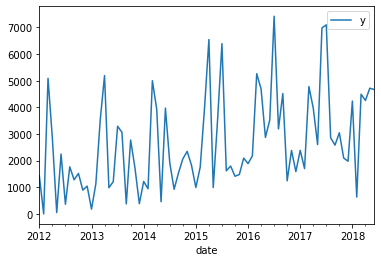

In [93]:
Y_train.query('key==683').set_index('date')[['y']].plot()

# Checking for NA in y_train

In [118]:
y_train_null=Y_train[Y_train.y.isnull()]

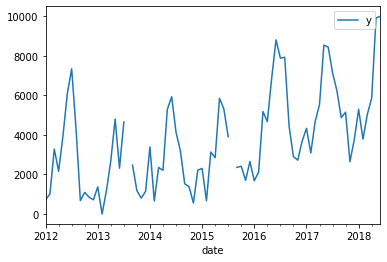

In [117]:
Y_train.query('key==95121').set_index('date')[['y']].plot()

# Replacing NAs with the average of previous and next months values for y_train

In [207]:
for i in np.arange(y_train_null.shape[0]):
    key=y_train_null.iloc[i]['key']
    date=y_train_null.iloc[i]['date']
    prev_month=date-datetime.timedelta(days=1)
    prev_month=prev_month.replace(day=1)
    next_month=date+datetime.timedelta(days=32)
    next_month=next_month.replace(day=1)
    prev_y=Y_train.loc[(Y_train['date']==prev_month)&(Y_train['key']==key),'y']
    next_y=Y_train.loc[(Y_train['date']==next_month)&(Y_train['key']==key),'y']
    if len(prev_y)!=0 and len(next_y)!=0:
        avg_y=(prev_y.values[0]+next_y.values[0])/2
    if len(prev_y)==0 and len(next_y)!=0:
        avg_y=next_y.values[0]
    if len(prev_y)!=0 and len(next_y)==0:
        avg_y=prev_y.values[0]
    Y_train.loc[(Y_train['date']==date)&(Y_train['key']==key),'y']=avg_y
    #print(date,prev_month,next_month,prev_y)

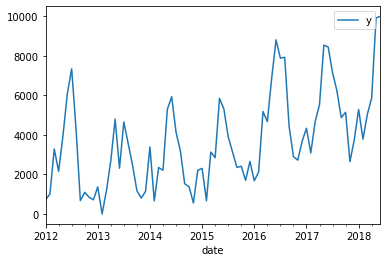

In [209]:
Y_train.query('key==95121').set_index('date')[['y']].plot()

# Checking and filling nas with zero for X_train, X_test 


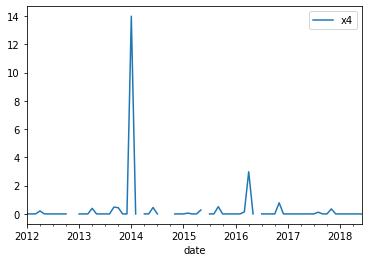

In [114]:
X_train.query('key==99444').set_index('date')[['x4']].plot()

## Looking at the above charts it is safe to replace Nulls with 0 for X_train

In [115]:
X_train=X_train.fillna(0)
X_test=X_test.fillna(0)

In [214]:
print(X_train.shape)
df_train=X_train.merge(Y_train,on=['key','date'],how='inner')
print(df_train.shape)

print(X_test.shape)
df_test=X_test.merge(Y_test,on=['key','date'],how='inner')
print(df_test.shape)

(8437, 114)
(8437, 115)
(1428, 114)
(1428, 115)


# Creating Features to input into LSTM model , taking a window of 24 months to predict the future 

In [273]:
df_train_1=df_train.set_index(['key','date']).unstack(level=1).fillna(0)
df_train_2=df_train_1.stack(level=1)
df_train_2=df_train_2.reset_index()
column_to_index='date'
month_seris=pd.Series(sorted(set(df_train_2[column_to_index])))
len_time_steps=24
starting_numeric_index=0
ending_numeric_index=len(month_seris)-len_time_steps
features_for_modelling=[]
target_for_modelling=[]
non_features_for_modelling=[]
feature_names=features_columns
target_names=['y']
non_features=['key','date']  # this will help us track if the array generated by the code is correct or not
for key in set(df_train_2.key):
    store_feature=df_train_2[df_train_2['key']==key]
    for i in np.arange(starting_numeric_index,ending_numeric_index):
        non_store_feature_for_the_iteration=store_feature[store_feature[column_to_index].isin(month_seris[i:i+len_time_steps])][non_features]
        store_feature_for_the_iteration=store_feature[store_feature[column_to_index].isin(month_seris[i:i+len_time_steps])][feature_names]
        target_feature_for_the_iteration=store_feature[store_feature[column_to_index]==month_seris[i+len_time_steps]][target_names]
        non_features_for_modelling.append(non_store_feature_for_the_iteration.values)
        features_for_modelling.append(store_feature_for_the_iteration.values)
        target_for_modelling.append(target_feature_for_the_iteration.values)
model_X=np.array(features_for_modelling)
target_Y=np.array(target_for_modelling)
non_feature_array=np.array(non_features_for_modelling)

In [263]:
#QCing if the code worked correctly

In [280]:
non_features_for_modelling[100]

array([[39943, Timestamp('2015-11-01 00:00:00')],
       [39943, Timestamp('2015-12-01 00:00:00')],
       [39943, Timestamp('2016-01-01 00:00:00')],
       [39943, Timestamp('2016-02-01 00:00:00')],
       [39943, Timestamp('2016-03-01 00:00:00')],
       [39943, Timestamp('2016-04-01 00:00:00')],
       [39943, Timestamp('2016-05-01 00:00:00')],
       [39943, Timestamp('2016-06-01 00:00:00')],
       [39943, Timestamp('2016-07-01 00:00:00')],
       [39943, Timestamp('2016-08-01 00:00:00')],
       [39943, Timestamp('2016-09-01 00:00:00')],
       [39943, Timestamp('2016-10-01 00:00:00')],
       [39943, Timestamp('2016-11-01 00:00:00')],
       [39943, Timestamp('2016-12-01 00:00:00')],
       [39943, Timestamp('2017-01-01 00:00:00')],
       [39943, Timestamp('2017-02-01 00:00:00')],
       [39943, Timestamp('2017-03-01 00:00:00')],
       [39943, Timestamp('2017-04-01 00:00:00')],
       [39943, Timestamp('2017-05-01 00:00:00')],
       [39943, Timestamp('2017-06-01 00:00:00')],


In [276]:
features_for_modelling[100][0]

array([ 5.77220731e-01,  2.51260161e+00,  2.67862601e+01,  2.19771194e+02,
        0.00000000e+00,  0.00000000e+00,  1.61647955e+00,  0.00000000e+00,
       -7.38240489e+00,  4.49080327e+02,  0.00000000e+00,  5.32886944e+00,
        6.28150402e-01,  1.94529827e+03,  5.40916242e+03,  3.22295483e+01,
        7.76675474e+02,  2.98467738e+01,  0.00000000e+00,  7.14410148e+00,
        1.18716995e+02,  0.00000000e+00,  1.49557114e+00,  0.00000000e+00,
        0.00000000e+00,  1.71259076e-01, -4.64094480e-01,  1.23179686e+02,
        2.85538111e+00,  1.21348605e+02,  1.85545723e-01,  6.51684473e+01,
        3.80712726e+02,  1.39233281e+01,  0.00000000e+00,  1.01306674e+03,
        1.34461047e+01,  8.67867100e+02,  1.05020128e+02,  1.92606352e+03,
        2.53880319e+01,  0.00000000e+00,  5.93472557e+01,  0.00000000e+00,
        6.65425146e-01,  4.46177196e+01,  1.43716100e+02,  2.12668551e+00,
        8.93032773e+01,  2.04071510e+02,  0.00000000e+00,  1.93499091e+01,
        0.00000000e+00,  

In [279]:
target_for_modelling[100]

array([[1739.753904]])

In [283]:
df_train.query('key==39943')

,key,date,x1,x2,x3,x4,x5,x6,x7,x8,...,x104,x105,x106,x107,x108,x109,x110,x111,x112,y
3204,39943,2015-01-01,0.000000,0.084830,0.000000,0.000000,8.099695,0.000000,17.954100,1.258629,...,123.137815,10.630113,46.858779,5.304635,0.000000,3.124220,0.706560,15.835844,0.000000,500.288019
3205,39943,2015-02-01,0.000000,0.550694,0.000000,0.000000,226.793460,0.000000,9.309890,52.203336,...,22.281936,4.088150,695.641313,892.368755,0.000000,2.521434,-0.269696,189.520014,72.831749,49.681132
3206,39943,2015-03-01,0.000000,0.510565,0.000000,0.000000,0.000000,0.000000,6.925108,341.997235,...,3.075749,0.000000,3.760479,3.324099,0.000000,4.432045,1.366664,3.054677,0.000000,1493.873619
3207,39943,2015-04-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,26.691286,0.000000,...,0.080235,0.000000,774.762726,20.552857,0.000000,5.712202,0.231507,294.986594,0.404943,1518.411436
3208,39943,2015-05-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.278829,201.339200,...,1.919982,0.000000,34.864799,1.964709,0.000000,6.989716,0.627906,10.824618,0.000000,3037.273940
3209,39943,2015-06-01,0.000000,0.000000,0.000000,1.139365,0.011519,0.000000,413.071691,3.960776,...,2.687361,0.000000,9.911066,-0.000031,0.000000,4.436694,0.000000,2.855609,0.000000,4056.743709
3210,39943,2015-07-01,0.000000,0.000000,0.000000,0.000000,42.331677,0.000000,0.961521,227.954086,...,3735.029991,11.283861,195.569398,16.971228,0.000000,1.894440,-8.517167,30.444421,4.000294,5650.093470
3211,39943,2015-08-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,73.360043,...,3.719334,0.000000,25.585055,36.032992,0.000000,1.889690,1.338387,22.667814,1.092652,3639.537303
3212,39943,2015-09-01,0.000000,0.000000,0.000000,0.166623,54.602182,0.000000,315.275179,70.198303,...,5.362570,0.000000,143.371823,56.148518,0.000000,1.886925,1.652273,112.668578,2.586124,1164.282276
3213,39943,2015-10-01,0.000000,0.000000,0.000000,0.980104,0.000000,0.000000,50.191459,3.198316,...,3.685123,0.031048,61.656691,51.119458,0.000000,2.512602,0.238181,7.323571,-3.621490,1032.635166


In [298]:
class MV_LSTM(torch.nn.Module):
    def __init__(self,n_features,seq_length,output_values=1):
        super(MV_LSTM, self).__init__()
        self.n_features = n_features
        self.seq_len = seq_length
        self.n_hidden = 20 # number of hidden states
        self.n_layers = 1 # number of LSTM layers (stacked)
        self.output_values=output_values
        
        self.l_lstm = torch.nn.LSTM(input_size = n_features, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True)
        # according to pytorch docs LSTM output is 
        # (batch_size,seq_len, num_directions * hidden_size)
        # when considering batch_first = True
        #print(self.n_hidden)
        #print(self.seq_len)
        #print(seq_length)
        #print(self.n_hidden*self.seq_len)
        self.l_linear = torch.nn.Linear(self.n_hidden*self.seq_len, output_values)
        
    
    def init_hidden(self, batch_size):
        # even with batch_first = True this remains same as docs
        hidden_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
        cell_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
        self.hidden = (hidden_state, cell_state)
    
    
    def forward(self, x):        
        batch_size, seq_len, _ = x.size()
        
        lstm_out, self.hidden = self.l_lstm(x,self.hidden)
        # lstm_out(with batch_first = True) is 
        # (batch_size,seq_len,num_directions * hidden_size)
        # for following linear layer we want to keep batch_size dimension and merge rest       
        # .contiguous() -> solves tensor compatibility error
        x = lstm_out.contiguous().view(batch_size,-1)
        #print(x.shape)
        #out=self.l_linear(x)
        x=F.relu(x)
        return self.l_linear(x)
        #return x,out
    
#criterion = torch.nn.MSELoss() 
criterion = torch.nn.L1Loss() #Because it was asked to used MAE loss which is same as L1 loss

   
n_features=model_X.shape[2]
n_timestep=model_X.shape[1]
output_values=target_Y.shape[2]
mv_net = MV_LSTM(n_features,n_timestep,output_values)

optimizer = torch.optim.Adam(mv_net.parameters(), lr=1e-1)

model_X=torch.tensor(model_X,dtype=torch.float32)
target_Y=torch.tensor(target_Y,dtype=torch.float32)
index_tensor=torch.from_numpy(np.arange(model_X.shape[0]))
dataset = torch.utils.data.TensorDataset(model_X, target_Y,index_tensor)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

#non_feature_array=torch.tensor(non_feature_array)
#feat_list=[non_feature_array,model_X,target_Y]

/Users/jauharim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/jauharim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


# running the model and appplying gradient clipping so that the gradient dont blow out of propotion

In [299]:
loss_list=[]
epochs=500
mv_net.train()
for e in range(epochs):
    batch_num=0
    for x_iter, y_iter,i_iter in dataloader:
        batch_num=batch_num+1
        
        optimizer.zero_grad()
        mv_net.init_hidden(x_iter.size(0))
        output=mv_net(x_iter).unsqueeze(1)
        loss = criterion(output, y_iter)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm(mv_net.parameters(), clip_value)
        optimizer.step() 
        if batch_num%50==0:
            loss_list.append(round(loss.item()/len(i_iter),2))
        if e%20==0 and batch_num%50==0:
            print('epoch : ',e, 'batch_num : ' , batch_num , 'loss : ' , round(loss.item()/len(i_iter),2))

epoch :  0 batch_num :  50 loss :  23.94
epoch :  20 batch_num :  50 loss :  15.02
epoch :  40 batch_num :  50 loss :  12.19
epoch :  60 batch_num :  50 loss :  14.9
epoch :  80 batch_num :  50 loss :  13.02
epoch :  100 batch_num :  50 loss :  13.33
epoch :  120 batch_num :  50 loss :  15.19


KeyboardInterrupt: 